# Nulling Fraction Simulation (*a la* PRB)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#from __future__ import division, print_function

%matplotlib inline

def norm(x, mean=0, sig=1):
    norm = 1/np.sqrt(2*np.pi)/sig
    arg = -0.5 * ((x-mean)/sig)**2
    return norm * np.exp(arg)

## basic test

The sum of $N$ draws from normal distribution $\mathcal{N}(\mu,\sigma)$ is $\mu \pm \sigma\sqrt{N}$.  Let's test it.

In [2]:
N = 1000  # number of noise points
M = 10000  # number of trials
S = 5.0  # standard deviation of samples
data = np.random.normal(scale=S, size=(M,N))
data.sort(axis=1)
csum = data.cumsum(axis=1)
print(csum.shape)

(10000, 1000)


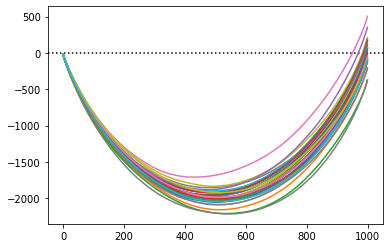

In [3]:
# plot first several trials:
plt.axhline(y=0, color='black', linestyle='dotted')
for ii in range(30):
    plt.plot(csum[ii])

AttributeError: 'Polygon' object has no property 'normed'

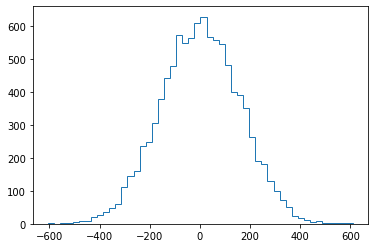

In [4]:
# plot hist of sum with expected gaussian
(counts, bins, h) = plt.hist(csum[:,-1], bins=50, normed=True, histtype='step')
gaus = norm(bins, sig=S*np.sqrt(N))
plt.plot(bins, gaus)

## determining $N$ from observed data

The expected sum assumes you know the number of null pulses *a priori*. But we want to infer that from data, which contains both on and off pulses.

Let's simulate a bunch of data sets that contain the same number of on and off pulses to see what happens.

In [ ]:
Ntot = 3000
Non = 2000
Noff = Ntot-Non

We will assume that on pulses are drawn from $\mathcal{N}(5,1)$ and off pulses from $\mathcal{N}(0,1)$.

For harder to distinguish on pulses we could increase the standard deviation of the on pulses or decrease the mean.

In [ ]:
trials = 5000
on = np.random.normal(loc=5, scale=1, size=(trials,Non))
off = np.random.normal(loc=0, scale=1, size=(trials,Noff))

In [ ]:
data = np.concatenate((off, on), axis=1)
data.sort(axis=1)
csum = data.cumsum(axis=1)
csum.shape

In [ ]:
# plot first several trials:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
ax1.axhline(y=0, color='black', linestyle='dotted')
for ii in range(30):
    ax1.plot(csum[ii])
ax1.set_xlim([0,1500])
ax1.set_ylim([-1000,2000])

ax2 = fig.add_subplot(122)
ax2.axhline(y=0, color='black', linestyle='dotted')
for ii in range(30):
    ax2.plot(csum[ii])
ax2.set_xlim([800,1100])
ax2.set_ylim([-200,200])


The data are samples from a joint distribution!  plot that!

In [ ]:
fig = plt.figure(figsize=(15,6))

# first several trials
ax1 = fig.add_subplot(121)
for ii in range(30):
    (counts, bins, h) = plt.hist(data[ii], bins=50, normed=True, histtype='step')

# all trials combined (with expected distr)
ax2 = fig.add_subplot(122)
(counts, bins, h) = plt.hist(data.flatten(), bins=50, normed=True, histtype='step')
fit = Noff/Ntot*norm(bins, mean=0, sig=1) + Non/Ntot*norm(bins, mean=5, sig=1)
plt.plot(bins, fit)

In [ ]:
zero_cross = np.where(np.diff(np.sign(csum)))[1]
print(zero_cross.shape)

In [ ]:
Nexp = zero_cross.mean()
Nstd = zero_cross.std()

In [ ]:
y_off = csum[:,1000]  # sum of first 1000
yave = y_off.mean()
ystd = y_off.std()

y_tru = np.sum(off, axis=1)  # sum of TRUE off pulse
yave_tru = y_tru.mean()
ystd_tru = y_tru.std()

In [ ]:
Nexp, Nstd, ystd, ystd_tru

The zero crossing seems like a good measure for well separated signals...

In [ ]:
kludge = 1/np.sqrt(6)

(counts, bins, h) = plt.hist(zero_cross, bins=50, normed=True, histtype='step')
gaus = norm(bins, mean=Nexp, sig=np.sqrt(Nexp)*kludge)
plt.plot(bins, gaus)

In [ ]:
np.sqrt(Nexp)  # this is stdev of y_off! not Nexp

* Nstd is idependent of the number of trials, hanging around 12-14.
* I'm pretty sure zero_cross is **not** normally distributed.
* Because of the change in slope as the on-pulses take over, when `y_off<0`, the path will rapidly cross zero and not be as "late" as you would expect.  This introduces some skewness to the distribution.

## Let's do Bayesian parameter estimation!

The likelihood is the joint distribution from above: the sum of two normal distributions, normalized by the number of observations drawn from each:

$$ \log\mathcal{L} = \frac{N_\mathrm{tot}-N_\mathrm{off}}{N_\mathrm{tot}} \mathcal{N}(\mu,\sigma) + \frac{N_\mathrm{off}}{N_\mathrm{tot}} \mathcal{N}(0,1)$$

In principle there are 3 free parameters: $N_\mathrm{off}, \mu, \sigma$ (although we should have pretty strict priors on the on pulse distribution other analyses).

In [ ]:
import emcee
from corner import corner

isq2pi = 1/(2*np.pi)

def logL(params, data):
    """likelihood"""
    Noff, u, sig = params
    N = len(data)
    
    norm = isq2pi/N
    
    norm_on = (N-Noff)/sig
    arg_on = -0.5 * ((data-u)/sig)**2
    norm_off = Noff
    arg_off = -0.5 * data**2
    
    logLs = np.log(norm * (norm_on*np.exp(arg_on) + norm_off*np.exp(arg_off)))
    
    return np.sum(logLs)

def logP(params):
    """prior"""
    p_mean = np.array([Nexp, 5., 1.])
    p_std = np.array([1.0e50, 0.5, 0.05]) # effective uniform prior on Noff    
    norm = isq2pi/p_std
    arg = -0.5 * ((params-p_mean)/p_std)**2
    print('arg',arg)
    return np.sum(np.log(norm)+arg, axis=-1)

def logPost(params, data):
    return logL(params, data) + logP(params)

In [ ]:
print(Nexp)
pTrue = [Nexp, 5., 1.]
logL(pTrue, data[0]), logP(pTrue)
print(data[0])
print(data[0].shape)

In [ ]:
sim = 0  # trial number from above
ndim = 3
nwalkers = 50
p0 = [pTrue + np.random.randn(ndim)*[5, 0.5, 0.05] for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logL, args=[data[sim]]) # no = uniform priors
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logPost, args=[data[sim]]) # strong prior on signal params

In [ ]:
pos, prob, state = sampler.run_mcmc(p0, 1000)  # burn in
sampler.reset()
pox, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)  # sample

In [ ]:
corner(sampler.flatchain, 50, labels=["Noff","on_mean","on_std"], truths=pTrue)

In [ ]:
print("Noff = {:.2f}".format(sampler.flatchain[:,0].mean()))
print("zero_cross = {:d}".format(zero_cross[sim]))

In [ ]:
low, med, up = np.percentile(sampler.flatchain[:,0], [18,50,86])

In [ ]:
print("           +{:.0f}".format(up-med))
print("Noff = {:.0f}".format(med))
print("           -{:.0f}".format(med-low))

This gives an uncertainty that agrees with $\sqrt{N}$, and is roughly a factor of 2 larger than `Nstd` from the simulations...